In [1]:
from data_processing import Dataset
from torchvision import transforms
import matplotlib.pyplot as plt
from scipy.ndimage import maximum_filter
import numpy as np
from noise import NoiseScheduler
import torch
import torch.nn.functional as F
from jet_finding import *
from tqdm.notebook import tqdm
import random

seed = 22
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Set the device to custom GPU
gpu = torch.device("cuda:3" if torch.cuda.is_available() else "cpu") # change cuda:1 to number between 0 & 5
torch.cuda.set_device(gpu)

if torch.cuda.is_available():
    print("CUDA is available!")
    print("Number of available GPUs:", torch.cuda.device_count())
    print("Current GPU:", torch.cuda.current_device())
else:
    print("CUDA is not available. Running on CPU.")


CUDA is available!
Number of available GPUs: 6
Current GPU: 0


In [2]:
# Set to directory where data is stored
work_home = False
data_dir = "Datasets" if work_home else "/cephfs/dice/projects/L1T/diffusion/datasets/"

start_idx = 12000 # Adjust which events to look at from the dataset, make different to the training data 
end_idx = 12300
dataset = Dataset(end_idx-start_idx, (120, 72), signal_file=f"{data_dir}/CaloImages_signal.root", pile_up_file=f"{data_dir}/CaloImages_bkg.root", save=False, start_idx=start_idx, end_idx=end_idx)

In [3]:
dataset() #once this is cached, you don't have to re-load

In [4]:
new_dim=(64,64)

saturation_value = 512 # Change saturation value here (make same as training value)
dataset.preprocess(new_dim)     # ensure these have the same values as when the model was trained

INFO:root:re-sizing
re-sizing


In [5]:
preprocess = transforms.Compose(
        [
            transforms.ToTensor()
        ]
)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
# Extract horizontal strip from y=26 to y=38 (12 pixels tall)
# Change how much of image to train model on here
strip_size = 'full_image'

if strip_size == 'full_image':
    y_start = 0
    y_end = 64

elif strip_size == 'strip':
    y_start = 26
    y_end = 38

In [8]:
clean_frames = preprocess(dataset.signal).float().permute(1, 2, 0).unsqueeze(1)[:, :, y_start:y_end, :].to(device) #pytorch symantics
pile_up = preprocess(dataset.pile_up).float().permute(1, 2, 0).unsqueeze(1)[:, :, y_start:y_end, :].to(device)

In [9]:
# print (clean_frames[0].sum())
# clean_frames[clean_frames!=0] = 0
# print (clean_frames[0].sum())

In [10]:
testEvent=10

noise_scheduler = NoiseScheduler('pile-up')
timestep = torch.LongTensor([40]).to(device) #each unit of timestep represents an addtional 5 pile-up events
noisy_images = []
random_seed = np.random.randint(0, end_idx-start_idx)
noisy_image, noise = noise_scheduler.add_noise(clean_frame=clean_frames[testEvent].unsqueeze(0), noise_sample=pile_up, timestep=timestep, random_seed=random_seed, n_events = end_idx-start_idx)

plt.imshow(clean_frames[testEvent].cpu().squeeze())
plt.colorbar()
plt.title(f"Clean Image Event {testEvent}")

ValueError: not enough values to unpack (expected 4, got 3)

In [ ]:
from models_stripped_kernels import Model, UNetLite_hls

modtype = 'UNet_lite' # Change Model type here

if modtype == 'UNet2d':
    model = Model('UNet', new_dim)
    model = model.__getitem__()

elif modtype == 'UNet_lite':
    model = UNetLite_hls()

# Move model to GPU
model = model.to(device)    

print(model)

UNetLite_hls(
  (relu): ReLU()
  (pool): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (up): ConvTranspose2d(16, 16, kernel_size=(2, 2), stride=(2, 2))
  (emb1): Linear(in_features=4, out_features=1, bias=True)
  (convd1_1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (normd1_1): GroupNorm(8, 16, eps=1e-05, affine=True)
  (convd1_2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (normd1_2): GroupNorm(8, 16, eps=1e-05, affine=True)
  (emb2): Linear(in_features=4, out_features=16, bias=True)
  (convd2_1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (normd2_1): GroupNorm(8, 16, eps=1e-05, affine=True)
  (convd2_2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (normd2_2): GroupNorm(8, 16, eps=1e-05, affine=True)
  (emb4): Linear(in_features=4, out_features=16, bias=True)
  (convb1_1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (normb1_1): GroupNorm(8, 16, eps=1e-05, affine=Tru

/software/sa21722/miniconda3/envs/sd_env/lib/python3.9/site-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


In [ ]:
if modtype == 'UNet2d':
    # Use 1st line for huggingface trained model
    # Use 2nd line for retrained model

    trained_model_path = '/cephfs/dice/projects/L1T/diffusion/trained_models/trained_diffusor.pt'
    #trained_model_path = 'retrained_models_UNet2d/saturation=512/model_epoch_9.pt'

elif modtype == 'UNet_lite': 
    trained_model_path = 'trained_models_lite/saturation=512/model_epoch_9.pt' # Specify folder for which trained model here!

print(trained_model_path)

trained_models_lite/saturation=512/model_epoch_9.pt


In [ ]:
checkpoint = torch.load(trained_model_path, map_location=device)  # Ensure checkpoint is loaded to the correct device
model.load_state_dict(checkpoint)

<All keys matched successfully>

  0%|          | 0/300 [00:00<?, ?it/s]

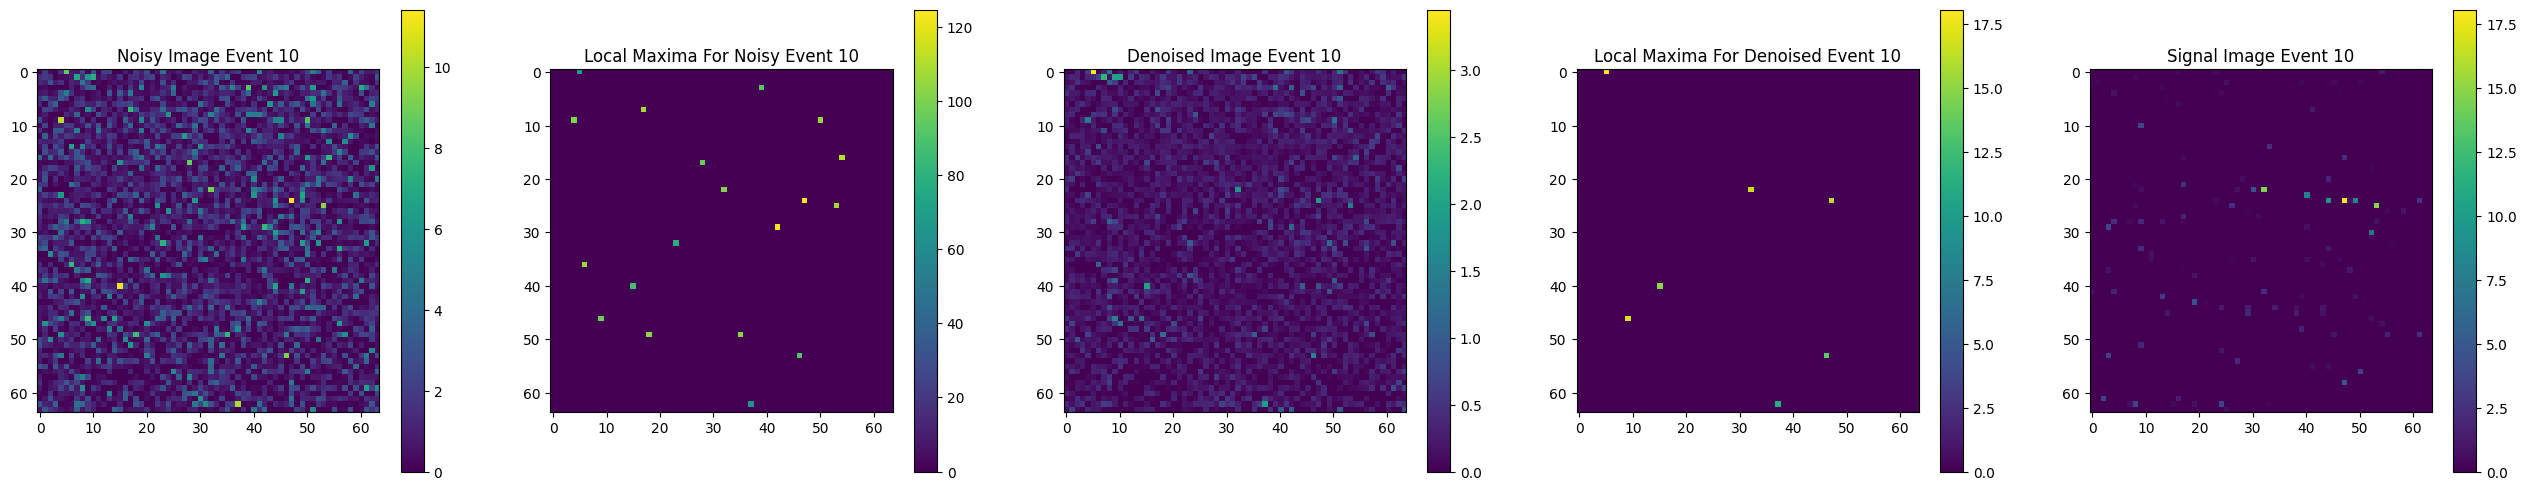

[{'i': 0, 'j': 5, 'pixel_value': tensor(8.7088), 'sum_around_maxima': 69.168816}, {'i': 3, 'j': 39, 'pixel_value': tensor(8.3831), 'sum_around_maxima': 92.087265}, {'i': 7, 'j': 17, 'pixel_value': tensor(7.5334), 'sum_around_maxima': 108.22754}, {'i': 9, 'j': 4, 'pixel_value': tensor(10.1526), 'sum_around_maxima': 101.15203}, {'i': 9, 'j': 50, 'pixel_value': tensor(8.2245), 'sum_around_maxima': 105.96607}, {'i': 16, 'j': 54, 'pixel_value': tensor(7.4705), 'sum_around_maxima': 111.78609}, {'i': 17, 'j': 28, 'pixel_value': tensor(8.7182), 'sum_around_maxima': 95.60534}, {'i': 22, 'j': 32, 'pixel_value': tensor(9.0951), 'sum_around_maxima': 101.38104}, {'i': 24, 'j': 47, 'pixel_value': tensor(11.4089), 'sum_around_maxima': 124.61979}, {'i': 25, 'j': 53, 'pixel_value': tensor(9.4348), 'sum_around_maxima': 108.28436}, {'i': 29, 'j': 42, 'pixel_value': tensor(7.6785), 'sum_around_maxima': 121.25891}, {'i': 32, 'j': 23, 'pixel_value': tensor(7.3025), 'sum_around_maxima': 78.81952}, {'i': 36, 

In [ ]:
denoised_images = []
jets_noisy_allEvents = []
jets_denoised_allEvents = []

progress_bar = tqdm(total=end_idx-start_idx)
progress_bar.set_description("Progress")

for event, noisy_image in enumerate(noisy_images):
    if modtype == 'UNet2d':
        noise_pred = model(noisy_image.unsqueeze(1), timestep, return_dict=False)[0][0]
    elif modtype == 'UNet_lite':
        noise_pred = model(noisy_image.unsqueeze(1), timestep)[0]

    de_noised = F.relu(noisy_image[0].cpu() - (noise_pred[0].detach().cpu()))
    denoised_images.append(de_noised)


    local_maxima_noisy, jets_noisy = find_local_maxima(noisy_image[0].cpu(), 9)
    jets_noisy_allEvents.append(jets_noisy)
    local_maxima_denoised, jets_denoised = find_local_maxima(de_noised, 9)
    jets_denoised_allEvents.append(jets_denoised)

    progress_bar.update(1)
    logs = {"Event": event}
    progress_bar.set_postfix(**logs)

    if event == testEvent:
        fig, axs = plt.subplots(1, 5, figsize=(32,6))

        im0 = axs[0].imshow(noisy_image[0].cpu().squeeze())
        axs[0].set_title(f"Noisy Image Event {testEvent}")
        fig.colorbar(im0, ax=axs[0])

        im1 = axs[1].imshow(local_maxima_noisy)
        axs[1].set_title(f"Local Maxima For Noisy Event {testEvent}")
        fig.colorbar(im1, ax=axs[1])

        im2 = axs[2].imshow(de_noised)
        axs[2].set_title(f"Denoised Image Event {testEvent}")
        fig.colorbar(im2, ax=axs[2])

        im3 = axs[3].imshow(local_maxima_denoised)
        axs[3].set_title(f"Local Maxima For Denoised Event {testEvent}")
        fig.colorbar(im3, ax=axs[3])

        im4 = axs[4].imshow(clean_frames[testEvent].cpu().squeeze())
        axs[4].set_title(f"Signal Image Event {testEvent}")
        fig.colorbar(im3, ax=axs[4])
        plt.show()

print(jets_noisy_allEvents[testEvent])
print(jets_denoised_allEvents[testEvent])



In [ ]:
leading_jet_noisy = []
leading_jet_denoised = []
print (jets_denoised_allEvents[0])

# The jet with the maximum sum_around_maxima is identified as the leading jet for both noisy and denoised images
for event in jets_noisy_allEvents:

    max_pt_jet = max(event, key=lambda x: x['sum_around_maxima'])
    
    # Append the max pt jet to the result list
    leading_jet_noisy.append(max_pt_jet)

for event in jets_denoised_allEvents:
    max_pt_jet = max(event, key=lambda x: x['sum_around_maxima'])
    
    # Append the max pt jet to the result list
    leading_jet_denoised.append(max_pt_jet)


[{'i': 45, 'j': 52, 'pixel_value': tensor(45.8322), 'sum_around_maxima': 100.04423}, {'i': 46, 'j': 59, 'pixel_value': tensor(40.3201), 'sum_around_maxima': 120.115234}, {'i': 61, 'j': 53, 'pixel_value': tensor(42.5981), 'sum_around_maxima': 71.88989}]


In [ ]:
print (leading_jet_noisy)

[{'i': 46, 'j': 59, 'pixel_value': tensor(41.0560), 'sum_around_maxima': 178.96948}, {'i': 12, 'j': 58, 'pixel_value': tensor(80.2404), 'sum_around_maxima': 179.89938}, {'i': 47, 'j': 13, 'pixel_value': tensor(14.5568), 'sum_around_maxima': 111.70938}, {'i': 28, 'j': 44, 'pixel_value': tensor(106.8593), 'sum_around_maxima': 268.7631}, {'i': 43, 'j': 7, 'pixel_value': tensor(71.9139), 'sum_around_maxima': 185.225}, {'i': 19, 'j': 60, 'pixel_value': tensor(99.1374), 'sum_around_maxima': 221.73459}, {'i': 32, 'j': 52, 'pixel_value': tensor(16.9830), 'sum_around_maxima': 118.57893}, {'i': 30, 'j': 30, 'pixel_value': tensor(46.3004), 'sum_around_maxima': 169.44319}, {'i': 32, 'j': 46, 'pixel_value': tensor(7.7517), 'sum_around_maxima': 123.37563}, {'i': 26, 'j': 12, 'pixel_value': tensor(61.6475), 'sum_around_maxima': 164.55035}, {'i': 24, 'j': 47, 'pixel_value': tensor(11.4089), 'sum_around_maxima': 124.61979}, {'i': 49, 'j': 61, 'pixel_value': tensor(61.7194), 'sum_around_maxima': 177.638

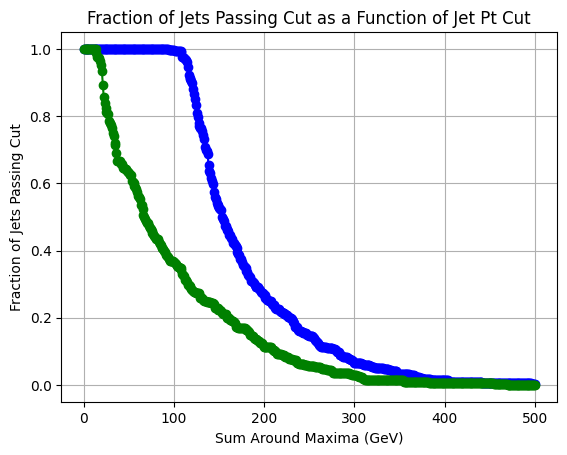

In [ ]:
cut_values = np.linspace(0, 500, 500)

pt_values_noisy = [jet['sum_around_maxima'] for jet in leading_jet_noisy]
fraction_passing_noisy = [sum(pt >= cut for pt in pt_values_noisy) / len(pt_values_noisy) for cut in cut_values]

pt_values_denoised = [jet['sum_around_maxima'] for jet in leading_jet_denoised]
fraction_passing_denoised = [sum(pt >= cut for pt in pt_values_denoised) / len(pt_values_denoised) for cut in cut_values]

plt.plot(cut_values, fraction_passing_noisy, marker='o', linestyle='-', color='b', label='Noisy Image')
plt.plot(cut_values, fraction_passing_denoised, marker='o', linestyle='-', color='g', label='Denoised Image')
plt.xlabel('Sum Around Maxima (GeV)')
plt.ylabel('Fraction of Jets Passing Cut')
plt.title('Fraction of Jets Passing Cut as a Function of Jet Pt Cut')
plt.grid(True)
plt.show()